# Image generation with Stable Cascade and OpenVINO

[Stable Cascade](https://huggingface.co/stabilityai/stable-cascade) is built upon the [Würstchen](https://openreview.net/forum?id=gU58d5QeGv) architecture and its main difference to other models like Stable Diffusion is that it is working at a much smaller latent space. Why is this important? The smaller the latent space, the faster you can run inference and the cheaper the training becomes. How small is the latent space? Stable Diffusion uses a compression factor of 8, resulting in a 1024x1024 image being encoded to 128x128. Stable Cascade achieves a compression factor of 42, meaning that it is possible to encode a 1024x1024 image to 24x24, while maintaining crisp reconstructions. The text-conditional model is then trained in the highly compressed latent space.

<img src="https://huggingface.co/stabilityai/stable-cascade/resolve/main/figures/collage_1.jpg"> 

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/stable-cascade-image-generation/stable-cascade-image-generation.ipynb" />


#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Load the original model](#Load-the-original-model)
    - [Infer the original model](#Infer-the-original-model)
- [Convert the model to OpenVINO IR](#Convert-the-model-to-OpenVINO-IR)
    - [Prior pipeline](#Prior-pipeline)
    - [Decoder pipeline](#Decoder-pipeline)
- [Select inference device](#Select-inference-device)
- [Building the pipeline](#Building-the-pipeline)
- [Inference](#Inference)
- [Interactive inference](#Interactive-inference)
### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
%pip install -q "diffusers>=0.27.0" accelerate datasets gradio transformers "nncf>=2.10.0" "openvino>=2024.1.0" "torch>=2.1" --extra-index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.


## Load and run the original pipeline
[back to top ⬆️](#Table-of-contents:)

In [2]:
import torch
from diffusers import StableCascadeDecoderPipeline, StableCascadePriorPipeline

prompt = "an image of a shiba inu, donning a spacesuit and helmet"
negative_prompt = ""

prior = StableCascadePriorPipeline.from_pretrained("stabilityai/stable-cascade-prior", torch_dtype=torch.float32)
decoder = StableCascadeDecoderPipeline.from_pretrained("stabilityai/stable-cascade", torch_dtype=torch.float32)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

To reduce memory usage, we skip the original inference. If you want run it, turn it.

In [3]:
import ipywidgets as widgets


run_original_inference = widgets.Checkbox(
    value=False,
    description="Run original inference",
    disabled=False,
)

run_original_inference

Checkbox(value=False, description='Run original inference')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

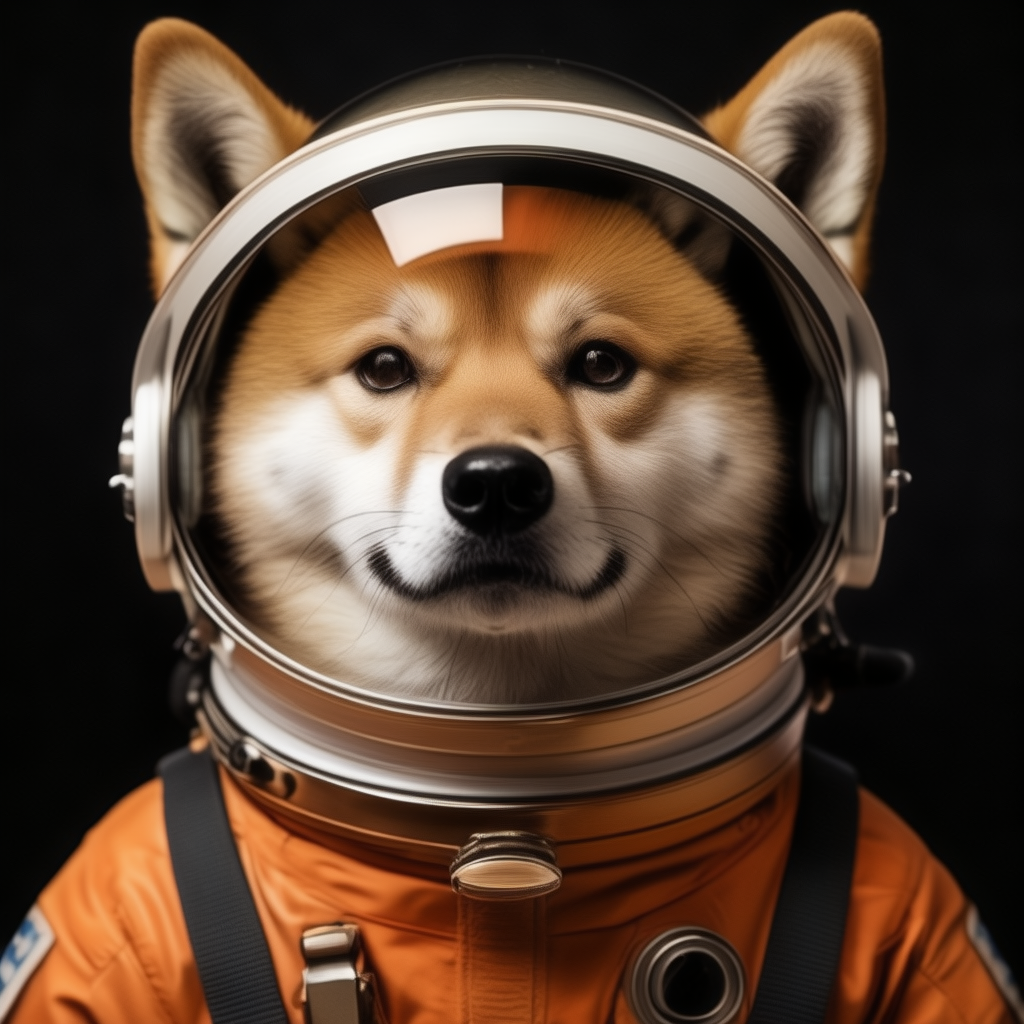

In [4]:
if run_original_inference.value:
    prior.to(torch.device("cpu"))
    prior_output = prior(
        prompt=prompt,
        height=1024,
        width=1024,
        negative_prompt=negative_prompt,
        guidance_scale=4.0,
        num_images_per_prompt=1,
        num_inference_steps=20,
    )

    decoder_output = decoder(
        image_embeddings=prior_output.image_embeddings,
        prompt=prompt,
        negative_prompt=negative_prompt,
        guidance_scale=0.0,
        output_type="pil",
        num_inference_steps=10,
    ).images[0]
    display(decoder_output)

## Convert the model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

Stable Cascade has 2 components:
- Prior stage `prior`: create low-dimensional latent space representation of the image using text-conditional LDM
- Decoder stage `decoder`: using representation from Prior Stage, produce a latent image in latent space of higher dimensionality using LDM and using VQGAN-decoder, decode the latent image to yield a full-resolution output image.

Let's define the conversion function for PyTorch modules. We use `ov.convert_model` function to obtain OpenVINO Intermediate Representation object and `ov.save_model` function to save it as XML file. We use `nncf.compress_weights` to [compress model weights](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html#compress-model-weights) to 8-bit to reduce model size.

In [5]:
import gc
from pathlib import Path

import openvino as ov
import nncf


MODELS_DIR = Path("models")


def convert(model: torch.nn.Module, xml_path: str, example_input, input_shape=None):
    xml_path = Path(xml_path)
    if not xml_path.exists():
        model.eval()
        xml_path.parent.mkdir(parents=True, exist_ok=True)
        with torch.no_grad():
            if not input_shape:
                converted_model = ov.convert_model(model, example_input=example_input)
            else:
                converted_model = ov.convert_model(model, example_input=example_input, input=input_shape)
        converted_model = nncf.compress_weights(converted_model)
        ov.save_model(converted_model, xml_path)
        del converted_model

        # cleanup memory
        torch._C._jit_clear_class_registry()
        torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
        torch.jit._state._clear_class_state()

        gc.collect()

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, openvino


### Prior pipeline
[back to top ⬆️](#Table-of-contents:)

This pipeline consists of text encoder and prior diffusion model. From here, we always use fixed shapes in conversion by using an `input_shape` parameter to generate a less memory-demanding model.

In [6]:
PRIOR_TEXT_ENCODER_OV_PATH = MODELS_DIR / "prior_text_encoder_model.xml"

prior.text_encoder.config.output_hidden_states = True


class TextEncoderWrapper(torch.nn.Module):
    def __init__(self, text_encoder):
        super().__init__()
        self.text_encoder = text_encoder

    def forward(self, input_ids, attention_mask):
        outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        return outputs["text_embeds"], outputs["last_hidden_state"], outputs["hidden_states"]


convert(
    TextEncoderWrapper(prior.text_encoder),
    PRIOR_TEXT_ENCODER_OV_PATH,
    example_input={
        "input_ids": torch.zeros(1, 77, dtype=torch.int32),
        "attention_mask": torch.zeros(1, 77),
    },
    input_shape={"input_ids": ((1, 77),), "attention_mask": ((1, 77),)},
)
del prior.text_encoder
gc.collect();

In [7]:
PRIOR_PRIOR_MODEL_OV_PATH = MODELS_DIR / "prior_prior_model.xml"

convert(
    prior.prior,
    PRIOR_PRIOR_MODEL_OV_PATH,
    example_input={
        "sample": torch.zeros(2, 16, 24, 24),
        "timestep_ratio": torch.ones(2),
        "clip_text_pooled": torch.zeros(2, 1, 1280),
        "clip_text": torch.zeros(2, 77, 1280),
        "clip_img": torch.zeros(2, 1, 768),
    },
    input_shape=[((-1, 16, 24, 24),), ((-1),), ((-1, 1, 1280),), ((-1, 77, 1280),), (-1, 1, 768)],
)
del prior.prior
gc.collect();

### Decoder pipeline
[back to top ⬆️](#Table-of-contents:)

Decoder pipeline consists of 3 parts: decoder, text encoder and VQGAN.

In [8]:
DECODER_TEXT_ENCODER_MODEL_OV_PATH = MODELS_DIR / "decoder_text_encoder_model.xml"

convert(
    TextEncoderWrapper(decoder.text_encoder),
    DECODER_TEXT_ENCODER_MODEL_OV_PATH,
    example_input={
        "input_ids": torch.zeros(1, 77, dtype=torch.int32),
        "attention_mask": torch.zeros(1, 77),
    },
    input_shape={"input_ids": ((1, 77),), "attention_mask": ((1, 77),)},
)

del decoder.text_encoder
gc.collect();

In [9]:
DECODER_DECODER_MODEL_OV_PATH = MODELS_DIR / "decoder_decoder_model.xml"

convert(
    decoder.decoder,
    DECODER_DECODER_MODEL_OV_PATH,
    example_input={
        "sample": torch.zeros(1, 4, 256, 256),
        "timestep_ratio": torch.ones(1),
        "clip_text_pooled": torch.zeros(1, 1, 1280),
        "effnet": torch.zeros(1, 16, 24, 24),
    },
    input_shape=[((-1, 4, 256, 256),), ((-1),), ((-1, 1, 1280),), ((-1, 16, 24, 24),)],
)
del decoder.decoder
gc.collect();

In [10]:
VQGAN_PATH = MODELS_DIR / "vqgan_model.xml"


class VqganDecoderWrapper(torch.nn.Module):
    def __init__(self, vqgan):
        super().__init__()
        self.vqgan = vqgan

    def forward(self, h):
        return self.vqgan.decode(h)


convert(
    VqganDecoderWrapper(decoder.vqgan),
    VQGAN_PATH,
    example_input=torch.zeros(1, 4, 256, 256),
    input_shape=(1, 4, 256, 256),
)
del decoder.vqgan
gc.collect();

## Select inference device
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO.

In [11]:
core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

## Building the pipeline
[back to top ⬆️](#Table-of-contents:)

Let's create callable wrapper classes for compiled models to allow interaction with original pipelines. Note that all of wrapper classes return `torch.Tensor`s instead of `np.array`s.

In [12]:
from collections import namedtuple


BaseModelOutputWithPooling = namedtuple("BaseModelOutputWithPooling", ["text_embeds", "last_hidden_state", "hidden_states"])


class TextEncoderWrapper:
    dtype = torch.float32  # accessed in the original workflow

    def __init__(self, text_encoder_path, device):
        self.text_encoder = core.compile_model(text_encoder_path, device.value)

    def __call__(self, input_ids, attention_mask, output_hidden_states=True):
        output = self.text_encoder({"input_ids": input_ids, "attention_mask": attention_mask})
        text_embeds = output[0]
        last_hidden_state = output[1]
        hidden_states = list(output.values())[1:]
        return BaseModelOutputWithPooling(torch.from_numpy(text_embeds), torch.from_numpy(last_hidden_state), [torch.from_numpy(hs) for hs in hidden_states])

In [13]:
class PriorPriorWrapper:
    def __init__(self, prior_path, device):
        self.prior = core.compile_model(prior_path, device.value)
        self.config = namedtuple("PriorWrapperConfig", ["clip_image_in_channels", "in_channels"])(768, 16)  # accessed in the original workflow
        self.parameters = lambda: (torch.zeros(i, dtype=torch.float32) for i in range(1))  # accessed in the original workflow

    def __call__(self, sample, timestep_ratio, clip_text_pooled, clip_text=None, clip_img=None, **kwargs):
        inputs = {
            "sample": sample,
            "timestep_ratio": timestep_ratio,
            "clip_text_pooled": clip_text_pooled,
            "clip_text": clip_text,
            "clip_img": clip_img,
        }
        output = self.prior(inputs)
        return [torch.from_numpy(output[0])]

In [14]:
class DecoderWrapper:
    dtype = torch.float32  # accessed in the original workflow

    def __init__(self, decoder_path, device):
        self.decoder = core.compile_model(decoder_path, device.value)

    def __call__(self, sample, timestep_ratio, clip_text_pooled, effnet, **kwargs):
        inputs = {"sample": sample, "timestep_ratio": timestep_ratio, "clip_text_pooled": clip_text_pooled, "effnet": effnet}
        output = self.decoder(inputs)
        return [torch.from_numpy(output[0])]

In [15]:
VqganOutput = namedtuple("VqganOutput", "sample")


class VqganWrapper:
    config = namedtuple("VqganWrapperConfig", "scale_factor")(0.3764)  # accessed in the original workflow

    def __init__(self, vqgan_path, device):
        self.vqgan = core.compile_model(vqgan_path, device.value)

    def decode(self, h):
        output = self.vqgan(h)[0]
        output = torch.tensor(output)
        return VqganOutput(output)

And insert wrappers instances in the pipeline:

In [16]:
prior.text_encoder = TextEncoderWrapper(PRIOR_TEXT_ENCODER_OV_PATH, device)
prior.prior = PriorPriorWrapper(PRIOR_PRIOR_MODEL_OV_PATH, device)
decoder.decoder = DecoderWrapper(DECODER_DECODER_MODEL_OV_PATH, device)
decoder.text_encoder = TextEncoderWrapper(DECODER_TEXT_ENCODER_MODEL_OV_PATH, device)
decoder.vqgan = VqganWrapper(VQGAN_PATH, device)

## Inference
[back to top ⬆️](#Table-of-contents:)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

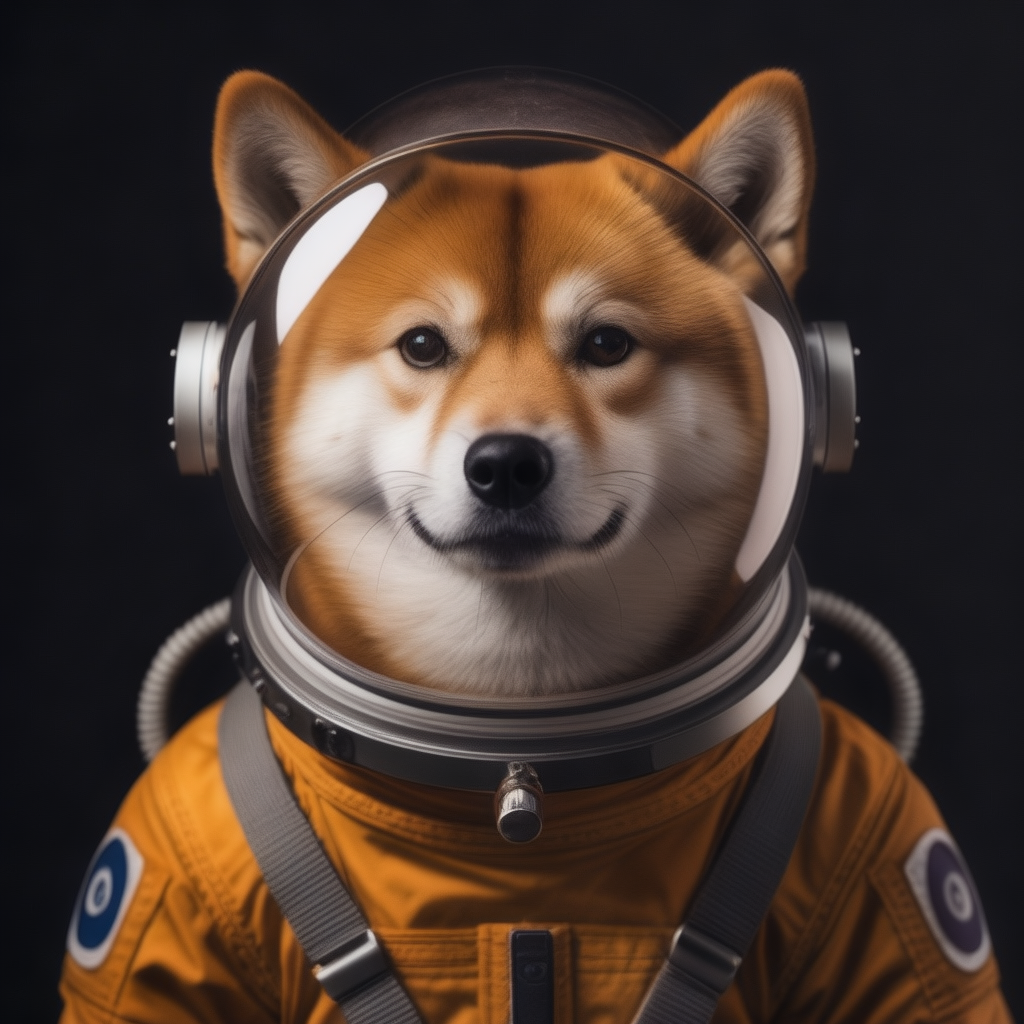

In [17]:
prior_output = prior(
    prompt=prompt,
    height=1024,
    width=1024,
    negative_prompt=negative_prompt,
    guidance_scale=4.0,
    num_images_per_prompt=1,
    num_inference_steps=20,
)

decoder_output = decoder(
    image_embeddings=prior_output.image_embeddings,
    prompt=prompt,
    negative_prompt=negative_prompt,
    guidance_scale=0.0,
    output_type="pil",
    num_inference_steps=10,
).images[0]
display(decoder_output)

## Interactive inference
[back to top ⬆️](#Table-of-contents:)

In [20]:
def generate(prompt, negative_prompt, prior_guidance_scale, decoder_guidance_scale, seed):
    generator = torch.Generator().manual_seed(seed)
    prior_output = prior(
        prompt=prompt,
        height=1024,
        width=1024,
        negative_prompt=negative_prompt,
        guidance_scale=prior_guidance_scale,
        num_images_per_prompt=1,
        num_inference_steps=20,
        generator=generator,
    )

    decoder_output = decoder(
        image_embeddings=prior_output.image_embeddings,
        prompt=prompt,
        negative_prompt=negative_prompt,
        guidance_scale=decoder_guidance_scale,
        output_type="pil",
        num_inference_steps=10,
        generator=generator,
    ).images[0]

    return decoder_output

In [ ]:
import gradio as gr
import numpy as np


demo = gr.Interface(
    generate,
    [
        gr.Textbox(label="Prompt"),
        gr.Textbox(label="Negative prompt"),
        gr.Slider(
            0,
            20,
            step=1,
            label="Prior guidance scale",
            info="Higher guidance scale encourages to generate images that are closely "
            "linked to the text `prompt`, usually at the expense of lower image quality. Applies to the prior pipeline",
        ),
        gr.Slider(
            0,
            20,
            step=1,
            label="Decoder guidance scale",
            info="Higher guidance scale encourages to generate images that are closely "
            "linked to the text `prompt`, usually at the expense of lower image quality. Applies to the decoder pipeline",
        ),
        gr.Slider(0, np.iinfo(np.int32).max, label="Seed", step=1),
    ],
    "image",
    examples=[["An image of a shiba inu, donning a spacesuit and helmet", "", 4, 0, 0], ["An armchair in the shape of an avocado", "", 4, 0, 0]],
    allow_flagging="never",
)
try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/